# Telecom Plan Revenue Statistical Data Analysis

This project aims to analyze the revenue generated by two prepaid plans, Surf and Ultimate, offered by the telecom operator Megaline. Through a preliminary analysis based on a dataset of 500 clients, this study seeks to understand client behavior and determine which prepaid plan is more lucrative for the company. This analysis is intended to support the commercial department in making informed decisions regarding the adjustment of the advertising budget.

Two hypotheses will be tested in this study:  
1. The average revenue from users of Ultimate and Surf calling plans differ.  
2. The average revenue from users in NY-NJ area is different from that of the users from other regions.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings
warnings.filterwarnings('ignore', 'use_inf_as_na option is deprecated')

# Load and Prepare Data

In [2]:
def load_data(file_name, sep=','):
    """
    Load data from a csv file.

    Parameters:
    - file_name (str): The name of the csv file to load.
    - sep (str, optional): The delimiter used in the csv file. Default is ','.

    Returns:
    - data (pandas.DataFrame or None): The loaded data as a pandas DataFrame, or None if the file is not found.

    The function first tries to load the csv file from the current directory. If the file is not found, it then tries to load it from the 'data_sets' directory (server directory).
    If the file is still not found, it prints an error message and returns None.

    Example usage:
    >>> data = load_data('data.csv')
    >>> print(data.head())
    """
    try:  # Local directory
        data = pd.read_csv(f"data/{file_name}", sep=sep)
    except:
        data = pd.read_csv(f"/datasets/{file_name}", sep=sep)
    return data
        

## Calls DataFrame

In [3]:
calls = load_data('megaline_calls.csv')
# Change the data type of the 'call_date' column to datetime
calls['call_date'] = pd.to_datetime(calls['call_date'])
# Rename duration column to denote units
calls.rename(columns={'duration': 'duration_minutes'}, inplace=True)
# Check for duplicates
print(f"Duplicate rows in the calls DataFrame: {calls.duplicated().sum()}")

print(
    f"Duplicate IDs in the calls DataFrame: {calls['id'].duplicated().sum()}")
# Review the call date column
print(f"Earliest call date: {calls['call_date'].min()}")
print(f"Latest call date: {calls['call_date'].max()}")

Duplicate rows in the calls DataFrame: 0
Duplicate IDs in the calls DataFrame: 0
Earliest call date: 2018-01-15 00:00:00
Latest call date: 2018-12-31 00:00:00


In [4]:
# Review the duration column
print(calls['duration_minutes'].describe())

count    137735.000000
mean          6.745927
std           5.839241
min           0.000000
25%           1.290000
50%           5.980000
75%          10.690000
max          37.600000
Name: duration_minutes, dtype: float64


In [5]:
# Duration should be rounded up to the nearest minute
# create new df where the duration is not a whole number
calls_not_whole = calls[~calls['duration_minutes'].apply(
    lambda x: x.is_integer())]

# Is there a pattern in the non-whole number durations with the call date?
# Print unique date values
print(calls_not_whole['call_date'].unique())

<DatetimeArray>
['2018-12-27 00:00:00', '2018-12-28 00:00:00', '2018-12-30 00:00:00',
 '2018-12-31 00:00:00', '2018-12-26 00:00:00', '2018-12-29 00:00:00',
 '2018-09-06 00:00:00', '2018-10-17 00:00:00', '2018-12-13 00:00:00',
 '2018-12-04 00:00:00',
 ...
 '2018-02-21 00:00:00', '2018-01-24 00:00:00', '2018-02-02 00:00:00',
 '2018-01-25 00:00:00', '2018-02-20 00:00:00', '2018-02-06 00:00:00',
 '2018-02-28 00:00:00', '2018-01-26 00:00:00', '2018-02-07 00:00:00',
 '2018-01-21 00:00:00']
Length: 351, dtype: datetime64[ns]


In [6]:
# Looks like almost every day within the data range has non-whole number durations
# Check for a pattern with the user_id
print(len(calls_not_whole['user_id'].unique()),
      "unique user IDs with non-whole number durations")

481 unique user IDs with non-whole number durations


In [7]:
# Check what percentage of calls have non-whole number durations
print(
    f"Percentage of calls with non-whole number durations: {len(calls_not_whole) / len(calls) * 100:.2f}%")

Percentage of calls with non-whole number durations: 79.67%


In [8]:
# That percentage is very high, I think the durations have not yet been rounded up to the nearest minute yet, I will do that now

# Round up the duration to the nearest minute
calls['duration_minutes'] = np.ceil(calls['duration_minutes']).astype(int)

# Review the duration column again
print(calls['duration_minutes'].describe())

count    137735.000000
mean          7.146673
std           5.953919
min           0.000000
25%           2.000000
50%           6.000000
75%          11.000000
max          38.000000
Name: duration_minutes, dtype: float64


In [9]:
# Delete calls_not_whole DataFrame
del calls_not_whole

In [10]:
calls.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 137735 entries, 0 to 137734
Data columns (total 4 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   id                137735 non-null  object        
 1   user_id           137735 non-null  int64         
 2   call_date         137735 non-null  datetime64[ns]
 3   duration_minutes  137735 non-null  int64         
dtypes: datetime64[ns](1), int64(2), object(1)
memory usage: 4.2+ MB


## Internet DataFrame

In [11]:
# Load the internet data
internet = load_data('megaline_internet.csv')

# Change the data type of the 'session_date' column to datetime
internet['session_date'] = pd.to_datetime(internet['session_date'])

# Change the data type for user_id to object
internet['user_id'] = internet['user_id'].astype('object')

# Check for duplicates
print(
    f"Duplicate rows in the internet DataFrame: {internet.duplicated().sum()}")

print(
    f"Duplicate IDs in the internet DataFrame: {internet['id'].duplicated().sum()}")

Duplicate rows in the internet DataFrame: 0
Duplicate IDs in the internet DataFrame: 0


In [12]:
internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 104825 entries, 0 to 104824
Data columns (total 4 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   id            104825 non-null  object        
 1   user_id       104825 non-null  object        
 2   session_date  104825 non-null  datetime64[ns]
 3   mb_used       104825 non-null  float64       
dtypes: datetime64[ns](1), float64(1), object(2)
memory usage: 3.2+ MB


## Messages DataFrame

In [13]:
# Load the messages data
messages = load_data('megaline_messages.csv')
# Change the data type of the 'message_date' column to datetime
messages['message_date'] = pd.to_datetime(messages['message_date'])

# Change the data type for user_id to object
messages['user_id'] = messages['user_id'].astype('object')

# Check for duplicates
print(
    f"Duplicate rows in the messages DataFrame: {messages.duplicated().sum()}")
print(
    f"Duplicate IDs in the messages DataFrame: {messages['id'].duplicated().sum()}")

Duplicate rows in the messages DataFrame: 0
Duplicate IDs in the messages DataFrame: 0


In [14]:
messages.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76051 entries, 0 to 76050
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   id            76051 non-null  object        
 1   user_id       76051 non-null  object        
 2   message_date  76051 non-null  datetime64[ns]
dtypes: datetime64[ns](1), object(2)
memory usage: 1.7+ MB


## Plans DataFrame

In [15]:
# Load the plans data
plans = load_data('megaline_plans.csv')

display(plans)

,messages_included,mb_per_month_included,minutes_included,usd_monthly_pay,usd_per_gb,usd_per_message,usd_per_minute,plan_name
0,50,15360,500,20,10,0.03,0.03,surf
1,1000,30720,3000,70,7,0.01,0.01,ultimate


## Users DataFrame

In [16]:
# Load the users data
users = load_data('megaline_users.csv')

# Change the data type of the 'reg_date' and 'churn_date' columns to datetime
users['reg_date'] = pd.to_datetime(users['reg_date'])
users['churn_date'] = pd.to_datetime(users['churn_date'])

# Change the data type for user_id to object
users['user_id'] = users['user_id'].astype('object')

# Check for duplicates
print(f"Duplicate rows in the users DataFrame: {users.duplicated().sum()}")
print(
    f"Duplicate User IDs in the users DataFrame: {users['user_id'].duplicated().sum()}")

Duplicate rows in the users DataFrame: 0
Duplicate User IDs in the users DataFrame: 0


In [17]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   user_id     500 non-null    object        
 1   first_name  500 non-null    object        
 2   last_name   500 non-null    object        
 3   age         500 non-null    int64         
 4   city        500 non-null    object        
 5   reg_date    500 non-null    datetime64[ns]
 6   plan        500 non-null    object        
 7   churn_date  34 non-null     datetime64[ns]
dtypes: datetime64[ns](2), int64(1), object(5)
memory usage: 31.4+ KB


# Transform and Feature Engineer

In [18]:
# For each user, find The number of calls made and minutes used per month
calls_per_user_per_month = calls.groupby(['user_id', calls['call_date'].dt.month])[
    'duration_minutes'].agg(['count', 'sum']).reset_index()

calls_per_user_per_month.columns = ['user_id', 'month', 'calls', 'minutes']

# Set user id as object type
calls_per_user_per_month['user_id'] = calls_per_user_per_month['user_id'].astype(
    'object')

calls_per_user_per_month.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2258 entries, 0 to 2257
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   user_id  2258 non-null   object
 1   month    2258 non-null   int32 
 2   calls    2258 non-null   int64 
 3   minutes  2258 non-null   int64 
dtypes: int32(1), int64(2), object(1)
memory usage: 61.9+ KB


In [19]:
# For each user, find The number of text messages sent per month
messages_per_user_per_month = messages.groupby(
    ['user_id', messages['message_date'].dt.month])['id'].count().reset_index()

messages_per_user_per_month.columns = ['user_id', 'month', 'messages']

# Set user id as object type
messages_per_user_per_month['user_id'] = messages_per_user_per_month['user_id'].astype(
    'object')

messages_per_user_per_month.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1806 entries, 0 to 1805
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   user_id   1806 non-null   object
 1   month     1806 non-null   int32 
 2   messages  1806 non-null   int64 
dtypes: int32(1), int64(1), object(1)
memory usage: 35.4+ KB


In [20]:
# For each user find The volume of data per month
internet_per_user_per_month = internet.groupby(
    ['user_id', internet['session_date'].dt.month])['mb_used'].sum().reset_index()

# Set user id as object type
internet_per_user_per_month['user_id'] = internet_per_user_per_month['user_id'].astype(
    'object')

# Rename the columns
internet_per_user_per_month.columns = ['user_id', 'month', 'mb_used']

internet_per_user_per_month.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2277 entries, 0 to 2276
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   user_id  2277 non-null   object 
 1   month    2277 non-null   int32  
 2   mb_used  2277 non-null   float64
dtypes: float64(1), int32(1), object(1)
memory usage: 44.6+ KB


In [21]:
# Merge the dataframes
# First merge calls_per_user_per_month with messages_per_user_per_month
usage_per_user_per_month = calls_per_user_per_month.merge(
    messages_per_user_per_month, on=['user_id', 'month'], how='outer')
# Then merge the result with internet_per_user_per_month
usage_per_user_per_month = usage_per_user_per_month.merge(
    internet_per_user_per_month, on=['user_id', 'month'], how='outer')

# Fill NaN values with 0
usage_per_user_per_month.fillna(0, inplace=True)

# Check that calls, minutes, messages, and gb used can be changed to int without losing data using array equality
list = ['calls', 'minutes', 'messages']
for col in list:
    if np.array_equal(usage_per_user_per_month[col].values, usage_per_user_per_month[col].astype(int).values):
        usage_per_user_per_month[col] = usage_per_user_per_month[col].astype(
            int)
    else:
        raise ValueError(
            f"Data will be lost if {col} column is changed to int")


usage_per_user_per_month.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2293 entries, 0 to 2292
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   user_id   2293 non-null   object 
 1   month     2293 non-null   int32  
 2   calls     2293 non-null   int64  
 3   minutes   2293 non-null   int64  
 4   messages  2293 non-null   int64  
 5   mb_used   2293 non-null   float64
dtypes: float64(1), int32(1), int64(3), object(1)
memory usage: 98.7+ KB


In [22]:
# Create function to calculate the monthly revenue for each user
def calculate_monthly_revenue(row, debug=False):
    """
    Calculate the monthly revenue for a user based on their usage and plan.

    Parameters:
    - row (pandas.Series): A row from the DataFrame containing user usage data.
    - debug (bool, optional): If True, additional debug information will be printed. Default is False.

    Returns:
    - total_revenue (float): The total monthly revenue for the user.

    Raises:
    - ValueError: If the user has more than one plan.

    Usage Example:
    >>> row = {'calls': 100, 'minutes': 500, 'messages': 50, 'mb_used': 1024, 'user_id': 1}
    >>> calculate_monthly_revenue(row, debug=True)
    """
    calls = row['calls']
    minutes = row['minutes']
    messages = row['messages']
    mb_used = row['mb_used']
    user_id = row['user_id']

    # Get the plan for the user from the users DataFrame
    # Verify there is only one plan for each user
    if len(users.loc[users['user_id'] == user_id, 'plan'].unique()) != 1:
        raise ValueError(f"User {user_id} has more than one plan")

    plan = users.loc[users['user_id'] == user_id, 'plan'].values[0]

    if debug:
        # Print the information for the user
        print(f"User ID: {user_id}")
        print(f"Plan: {plan}")
        print(f"Calls: {calls}")
        print(f"Minutes: {minutes}")
        print(f"Messages: {messages}")
        print(f"MB Used: {mb_used}")

    # Get the plan details
    messages_included = plans.loc[plans['plan_name']
                                  == plan, 'messages_included'].values[0]
    mb_included = plans.loc[plans['plan_name'] ==
                            plan, 'mb_per_month_included'].values[0]
    minutes_included = plans.loc[plans['plan_name']
                                 == plan, 'minutes_included'].values[0]
    usd_monthly_pay = plans.loc[plans['plan_name']
                                == plan, 'usd_monthly_pay'].values[0]
    usd_per_gb = plans.loc[plans['plan_name'] == plan, 'usd_per_gb'].values[0]
    usd_per_message = plans.loc[plans['plan_name']
                                == plan, 'usd_per_message'].values[0]
    usd_per_minute = plans.loc[plans['plan_name']
                               == plan, 'usd_per_minute'].values[0]

    if debug:
        # Print the plan information
        print(f"Messages Included: {messages_included}")
        print(f"MB Included: {mb_included}")
        print(f"Minutes Included: {minutes_included}")
        print(f"USD Monthly Pay: {usd_monthly_pay}")
        print(f"USD Per GB: {usd_per_gb}")
        print(f"USD Per Message: {usd_per_message}")
        print(f"USD Per Minute: {usd_per_minute}")

    # Calculate overages for each service
    messages_over = max(messages - messages_included, 0)
    mb_over = max(mb_used - mb_included, 0)
    minutes_over = max(minutes - minutes_included, 0)

    if debug:
        # Print the overages
        print(f"Messages Over: {messages_over}")
        print(f"MB Over: {mb_over}")
        print(f"Minutes Over: {minutes_over}")

    # Calculate the total revenue per service
    revenue_messages = messages_over * usd_per_message
    # Round up to the nearest GB before multiplying by the price per GB
    revenue_mb = np.ceil(mb_over / 1024) * usd_per_gb
    revenue_minutes = minutes_over * usd_per_minute

    if debug:
        # Print the revenue per service
        print(f"Revenue Messages: {revenue_messages}")
        print(f"Revenue MB: {revenue_mb}")
        print(f"Revenue Minutes: {revenue_minutes}")

    # Calculate the total revenue
    total_revenue = usd_monthly_pay + revenue_messages + revenue_mb + revenue_minutes

    return total_revenue

In [23]:
# Add the revenue column to the usage_per_user_per_month DataFrame
usage_per_user_per_month['revenue'] = usage_per_user_per_month.apply(
    calculate_monthly_revenue, axis=1)

usage_per_user_per_month.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2293 entries, 0 to 2292
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   user_id   2293 non-null   object 
 1   month     2293 non-null   int32  
 2   calls     2293 non-null   int64  
 3   minutes   2293 non-null   int64  
 4   messages  2293 non-null   int64  
 5   mb_used   2293 non-null   float64
 6   revenue   2293 non-null   float64
dtypes: float64(2), int32(1), int64(3), object(1)
memory usage: 116.6+ KB


In [24]:
# Describe the revenue column
print(usage_per_user_per_month['revenue'].describe())

count    2293.000000
mean       64.351147
std        46.624945
min        20.000000
25%        23.480000
50%        70.000000
75%        70.000000
max       590.370000
Name: revenue, dtype: float64


# Analyze

## Describe the Customers' Behavior.  
Find the minutes, texts, and volume of data the users of each plan require per month.

In [25]:
# Left Merge the usage_per_user_per_month DataFrame with the users DataFrame on user_id for plan information
usage_per_user_per_month = usage_per_user_per_month.merge(
    users[['user_id', 'plan']], on='user_id', how='left')

usage_per_user_per_month.info()
print()
display(usage_per_user_per_month.sample(10))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2293 entries, 0 to 2292
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   user_id   2293 non-null   object 
 1   month     2293 non-null   int32  
 2   calls     2293 non-null   int64  
 3   minutes   2293 non-null   int64  
 4   messages  2293 non-null   int64  
 5   mb_used   2293 non-null   float64
 6   revenue   2293 non-null   float64
 7   plan      2293 non-null   object 
dtypes: float64(2), int32(1), int64(3), object(2)
memory usage: 134.5+ KB



,user_id,month,calls,minutes,messages,mb_used,revenue,plan
874,1187,4,78,568,7,14572.78,22.04,surf
659,1144,4,21,163,21,8196.03,70.00,ultimate
389,1082,4,32,190,15,6874.38,20.00,surf
1173,1255,8,86,629,54,11136.87,70.00,ultimate
20,1006,12,9,59,139,32118.82,84.00,ultimate
2003,1439,5,46,295,55,13808.46,20.15,surf
415,1088,8,29,240,42,19089.65,70.00,ultimate
957,1203,12,69,483,46,12451.92,20.00,surf
2129,1470,5,28,240,51,0.00,20.03,surf
1238,1265,11,9,98,0,4181.99,20.00,surf


In [26]:
# Group the data by plan, calculate the mean for calls, minutes, messages, mb_used, and revenue for monthly average usage

average_monthly_usage_per_user = usage_per_user_per_month.groupby(['plan', 'user_id']).agg(
    'mean').reset_index()
# Set user_id as object type
average_monthly_usage_per_user['user_id'] = average_monthly_usage_per_user['user_id'].astype(
    'object')


average_monthly_usage_per_user.info()
display(average_monthly_usage_per_user.sample(10))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 490 entries, 0 to 489
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   plan      490 non-null    object 
 1   user_id   490 non-null    object 
 2   month     490 non-null    float64
 3   calls     490 non-null    float64
 4   minutes   490 non-null    float64
 5   messages  490 non-null    float64
 6   mb_used   490 non-null    float64
 7   revenue   490 non-null    float64
dtypes: float64(6), object(2)
memory usage: 30.8+ KB


,plan,user_id,month,calls,minutes,messages,mb_used,revenue
341,ultimate,1031,9.5,68.000000,491.166667,2.333333,15478.613333,70.00
456,ultimate,1412,9.0,135.000000,947.000000,48.000000,14934.024286,70.00
381,ultimate,1158,12.0,61.000000,476.000000,0.000000,21244.740000,70.00
355,ultimate,1062,7.5,36.000000,248.500000,8.000000,14823.662000,70.00
240,surf,1348,11.0,84.333333,688.666667,47.333333,13859.973333,25.72
409,ultimate,1247,9.5,71.000000,473.500000,100.000000,16712.875000,70.00
347,ultimate,1039,9.0,66.000000,459.142857,21.000000,18260.484286,70.00
236,surf,1342,12.0,65.000000,519.000000,7.000000,10998.390000,20.57
436,ultimate,1354,10.0,65.800000,439.600000,31.000000,14230.252000,70.00
91,surf,1137,11.0,0.000000,0.000000,56.000000,5611.086667,20.20


## Calculate Statistics and Visualize

In [27]:
def get_mode(pd_series):
    """
    Get the mode of a pandas Series as an int if just one mode, or a list if multiple modes, NaN if no mode.

    Parameters:
    pd_series (pandas.Series): The pandas Series for which to calculate the mode.

    Returns:
    int or list or NaN: The mode(s) of the pandas Series. If there is only one mode, it is returned as an int.
    If there are multiple modes, they are returned as a list. If there is no mode, NaN is returned.
    """
    mode = pd_series.mode()
    if len(mode) == 1:
        return int(mode.iloc[0])
    elif len(mode) > 4:
        return f'{len(mode)} modes found'
    elif len(mode) > 1:
        return mode.tolist()
    else:
        return np.nan

In [28]:
def calculate_stats(df, column, hue):
    
    # Get groups
    groups = df[hue].unique()
    
    # List to store desired statistics
    stats = ['mean', 'std', 'var', 'mode', 'max', 'min', 'limit', 'percent_above_limit','percent_below_limit', 'percent_above_mean', 'percent_below_mean']
    
    # Create df to store the results
    stats = pd.DataFrame(columns=groups, index=stats)
    
    for group in groups:
        # Get the mean for the group
        mean = df.loc[df[hue] == group, column].mean()
        # Get the standard deviation for the group
        std = df.loc[df[hue] == group, column].std()
        # Get the variance for the group
        var = df.loc[df[hue] == group, column].var()
        # Get the mode for the group as a Series
        mode = get_mode(df.loc[df[hue] == group, column])
        # Get the maximum for the group
        maximum = df.loc[df[hue] == group, column].max()
        # Get the minimum for the group
        minimum = df.loc[df[hue] == group, column].min()
        
        # Get the limit for the group
        try:  # For _included suffix
            limit = plans.loc[plans['plan_name'] == group, f'{column}_included'].values[0]
            # Get the number of users above the limit
            users_above_limit = len(df.loc[(df[hue] == group) & (df[column] > limit)])
            # Get the number of users below the limit
            users_below_limit = len(df.loc[(df[hue] == group) & (df[column] <= limit)])
            # Calculate percentages
            percent_above_limit = users_above_limit / len(df.loc[df[hue] == group]) * 100
            percent_below_limit = users_below_limit / len(df.loc[df[hue] == group]) * 100
        except:
            try:  # For mb_used
                # Remove the _used suffix
                column_fixed = column.replace('_used', '')
                # Assign the limit for the column
                limit = plans.loc[plans['plan_name'] == group, f'{column_fixed}_per_month_included'].values[0]
                # Get the number of users above the limit
                users_above_limit = len(df.loc[(df[hue] == group) & (df[column] > limit)])
                # Get the number of users below the limit
                users_below_limit = len(df.loc[(df[hue] == group) & (df[column] <= limit)])
                # Calculate percentages
                percent_above_limit = users_above_limit / len(df.loc[df[hue] == group]) * 100
                percent_below_limit = users_below_limit / len(df.loc[df[hue] == group]) * 100
            except:  # There is no limit for the column
                limit = np.NaN
                percent_above_limit = np.NaN
                percent_below_limit = np.NaN
    
        ### Mean ###
        # Get the number of users above the mean
        users_above_mean = len(df.loc[(df[hue] == group) & (df[column] > mean)])
        # Get the number of users below the mean
        users_below_mean = len(df.loc[(df[hue] == group) & (df[column] <= mean)])
        # Get the total number of users
        total_users = len(df.loc[df[hue] == group])
        
        # Calculate percentages for mean
        percent_above_mean = users_above_mean / total_users * 100
        percent_below_mean = users_below_mean / total_users * 100
        
        # Add the results to the df
        stats.loc['mean', group] = mean
        stats.loc['std', group] = std
        stats.loc['var', group] = var
        stats.loc['mode', group] = mode
        stats.loc['max', group] = maximum
        stats.loc['min', group] = minimum
        stats.loc['limit', group] = limit
        stats.loc['percent_above_limit', group] = percent_above_limit
        stats.loc['percent_below_limit', group] = percent_below_limit
        stats.loc['percent_above_mean', group] = percent_above_mean
        stats.loc['percent_below_mean', group] = percent_below_mean
    
    return stats

In [29]:
def plot_hist(df, column, hue, title='', save=False, mean_line=True, return_stats=False):
    
    # Set size of the plot
    plt.figure(figsize=(6, 5))
    
    sns.histplot(data=df, x=column, hue=hue, fill=True, kde=True)
    
    if mean_line:
        # Get the color palette
        palette = sns.color_palette(n_colors=len(df[hue].unique()))

        # Plot vertical lines with matching colors
        for i, e in enumerate(df[hue].unique()):
            mean_value = df[df[hue] == e][column].mean()
            plt.axvline(mean_value, linestyle='dashed', linewidth=1, color=palette[i])

    
    # Set the title
    plt.title(title)
    
    # Set x-axis label
    plt.xlabel("")
    
    # Legend
    plt.legend(title=hue.capitalize(), labels=df[hue].unique())
    
    if save:
        # Set the file name
        filename = f'overlaid_density_{hue}_{column}.png'
        # Save the plot to the 'images' directory
        try:
            plt.savefig(f'images/{filename}')
        except FileNotFoundError:
            print("The 'images' directory does not exist. Plot not saved.")
            
    # Show the plot
    plt.show()
    
    if return_stats:
        # Define the statistics variables
        stats = ['mean', 'var', 'std']
        # Df to store the results
        results = pd.DataFrame(columns=df[hue].unique(), index=stats)
        
        for e in df[hue].unique():
            for stat in stats:
                results.loc[stat, e] = df[df[hue] == e][column].agg(stat)
            
        
    if return_stats:
        return results
    else:
        return None
    

In [30]:
def plot_hist_sbs(df, column, hue, title='', save=False, mean_line=True, return_stats=False):
    """
    Plot and show side-by-side histograms for the specified column and hue, including statistics in the legend.
    NaN values are dropped per default sns behavior. Y axis is shared between the plots.

    Parameters:
        df (pandas.DataFrame): The DataFrame containing the data to plot.
        column (str): The column name to plot the histograms for.
        hue (str): The column name to use for coloring the histograms.
        title (str, optional): The title for the plot. Default is an empty string.
        save (bool, optional): Whether to save the plot as an image file to the 'images' directory. Default is False.
        mean_line (bool, optional): Whether to draw dashed lines for the mean. Default is True.
        return_stats (bool, optional): Whether to return a DataFrame with statistics. Default is False.

    Returns:
        pandas.DataFrame: A DataFrame containing statistics for the column for each hue.
    """
    # Create a figure with subplots equal to the number of unique values in the hue column
    groups = df[hue].unique()
    fig, axes = plt.subplots(1, len(groups), figsize=(12, 5), sharey=True)
    
    # Plot and calculate statistics for each group
    for i, group in enumerate(groups):
        # Plot
        data = df[df[hue] == group]
        sns.histplot(data=data, x=column, color=sns.color_palette()[i], ax=axes[i], stat='density', kde=True)
        
        # Calculate statistics
        mean = data[column].mean()
        var = data[column].var()
        std = data[column].std()
        
        if mean_line:
            axes[i].axvline(mean, color='black', linestyle='dashed', linewidth=1)
        
        axes[i].set_title(f'{hue.capitalize()}: {group}')
        axes[i].set_xlabel('')
        axes[i].legend([f'Mean: {mean:.2f}\nVar: {var:.2f}\nStd: {std:.2f}'])
        
    # Set super title
    fig.suptitle(title)
    
    # Layout
    plt.tight_layout(rect=[0, 0.05, 1, 0.95])
    
    if save:
        filename = f'side_by_side_density_{hue}_{column}.png'
        try:
            plt.savefig(f'images/{filename}')
        except FileNotFoundError:
            print("The 'images' directory does not exist. Plot not saved.")
    
    plt.show()
            
    if return_stats:
        # Define the statistics variables
        stats = ['mean', 'var', 'std']
        # Df to store the results
        results = pd.DataFrame(columns=groups, index=stats)
        
        for e in groups:
            for stat in stats:
                results.loc[stat, e] = df[df[hue] == e][column].agg(stat)
        
        return results
    
    else:
        return None

### Calls Data

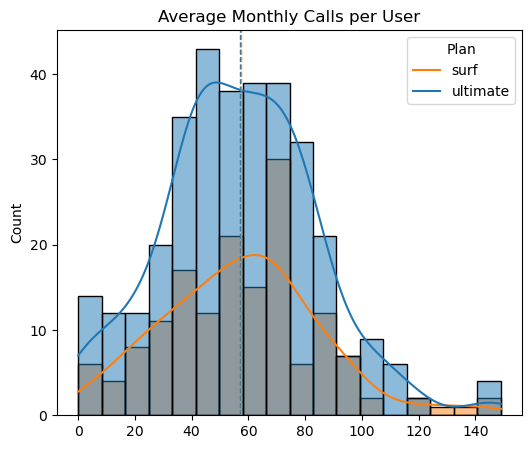

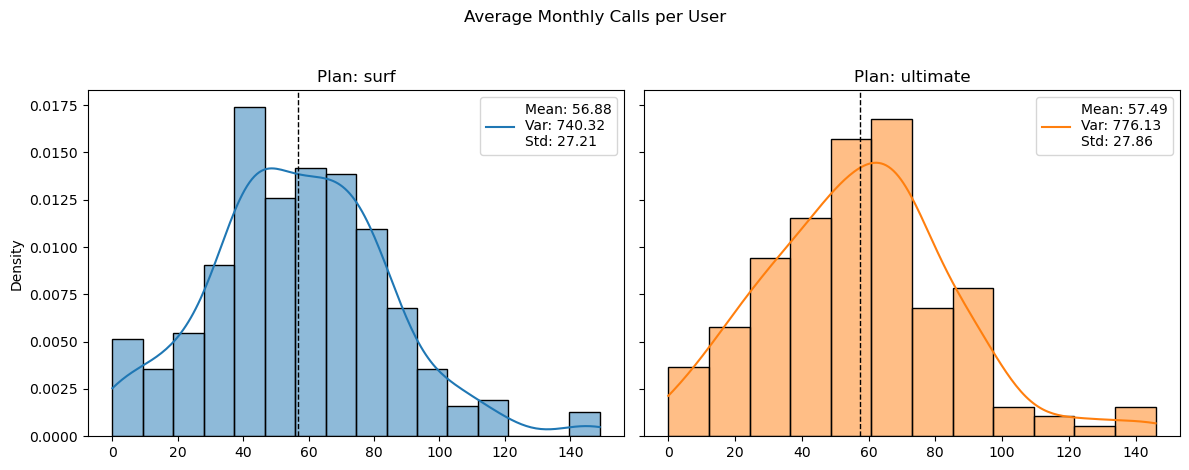

,surf,ultimate
mean,56.879065,57.490762
std,27.208734,27.859136
var,740.315208,776.131435
mode,0,38
max,149.0,146.0
min,0.0,0.0
limit,NaN,NaN
percent_above_limit,NaN,NaN
percent_below_limit,NaN,NaN
percent_above_mean,49.54955,49.681529


In [31]:
# Plot and Save for Calls
plot_hist(average_monthly_usage_per_user, 'calls', 'plan', 'Average Monthly Calls per User', save=True)
plot_hist_sbs(average_monthly_usage_per_user, 'calls', 'plan', 'Average Monthly Calls per User', save=True)
display(calculate_stats(average_monthly_usage_per_user, 'calls', 'plan'))

#### Describe the distributions:  

The histograms reveal a bell-shaped distribution for both plans, indicative of a pattern where most of the users have a call count near the average, with fewer users making significantly fewer or significantly more calls. There is a slight right skew in the data for both plans. 

For both plans, the average number of calls per user is in the mid-50s per month, with a similar standard deviation of around 27 for both, signifying that the spread of the data around the mean is similar across plans. This slight spread is more pronounced in the Ultimate plan, indicated by a marginally higher variance and standard deviation, hinting at a slightly broader range of call behaviors in this plan.

Given the similarity in their mean and standard deviations, the customer call behavior doesn't differ drastically between the two plans. Let's move on to looking at average monthly minutes, which should be more informative of call usage compared to the number of calls.

### Minutes Data

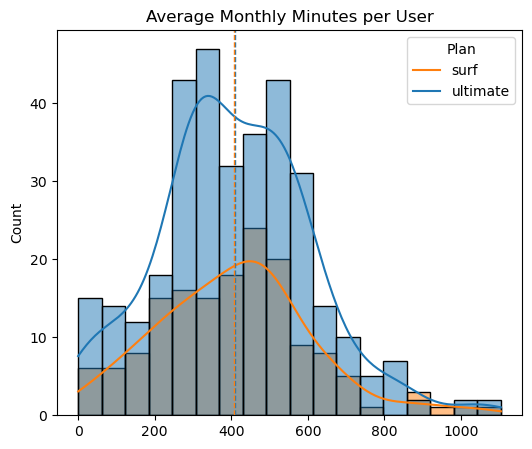

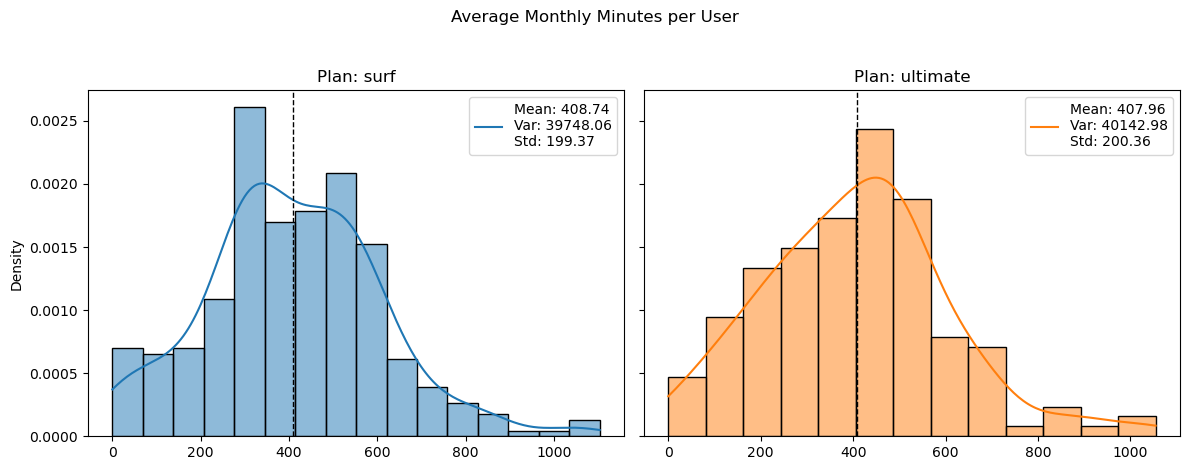

,surf,ultimate
mean,408.737038,407.959877
std,199.369158,200.357124
var,39748.061306,40142.977006
mode,0,"[0.0, 219.0, 502.0, 666.0]"
max,1104.0,1054.571429
min,0.0,0.0
limit,500,3000
percent_above_limit,33.033033,0.0
percent_below_limit,66.966967,100.0
percent_above_mean,48.948949,50.955414


In [32]:
# Plot and Save for Minutes
plot_hist(average_monthly_usage_per_user, 'minutes', 'plan', 'Average Monthly Minutes per User', save=True)
plot_hist_sbs(average_monthly_usage_per_user, 'minutes', 'plan', 'Average Monthly Minutes per User', save=True)
display(calculate_stats(average_monthly_usage_per_user, 'minutes', 'plan'))

#### Describe the distributions: 

- **Central Tendency and Shape:** Similar to Calls data, the histograms exhibit bell-shaped curves for both plans, indicating distributions with tendencies to cluster around a mean value. For Surf, the mean is approximately 408.74 minutes, and for Ultimate, it's about 407.96 minutes, suggesting that, on average, users from both plans consume similar amounts of minutes each month. The peak of the histogram for active users aligns with these means, though it's important to note that the statistical mode for the Surf plan is actually 0, indicating a significant number of users with no usage at all. 

- **Spread and Variability:** The standard deviations are roughly 200 for both plans, reflecting a considerable spread around the mean and similar variability in minutes used by customers. The variance figures support this observation, being quite close for both plans, indicating a consistent distribution of usage from the average.

- **Outliers and Skewness:** The presence of outliers is suggested by the maximum values, which are 1104 for Surf and 1054.57 for Ultimate, exceeding the average usage. This creates a slight right skewness in both distributions, more so for the Surf plan, indicating that a minority of users are heavy callers.  

- **Plan Limits:** The Surf plan includes 500 minutes, and the Ultimate plan offers a much more generous 3000 minutes. 33% of Surf users exceed their limit, which suggests that the allowance is not sufficient for a third of the users. In contrast, no Ultimate plan users exceed their limit, highlighting that the large allowance is more than adequate for all users on this plan.  

In summary, the minutes data for both plans suggest that there is a core of consistent usage among customers, with averages and spreads that are remarkably similar. However, the significant percentage of Surf users exceeding their limit contrasts sharply with the Ultimate users, who all stay within their more generous allotment. The skewness in both distributions and the modes indicate that there are both inactive users and those with high usage needs.

### Messages Data

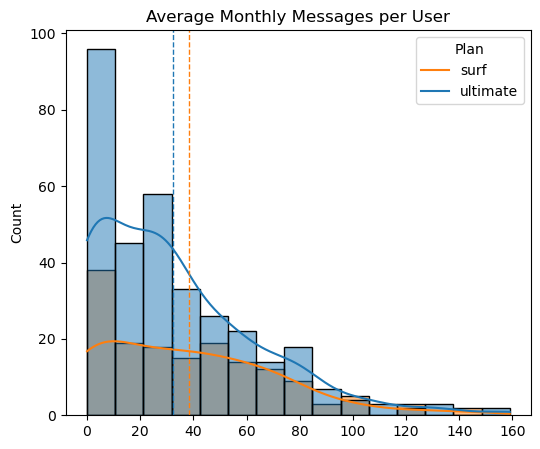

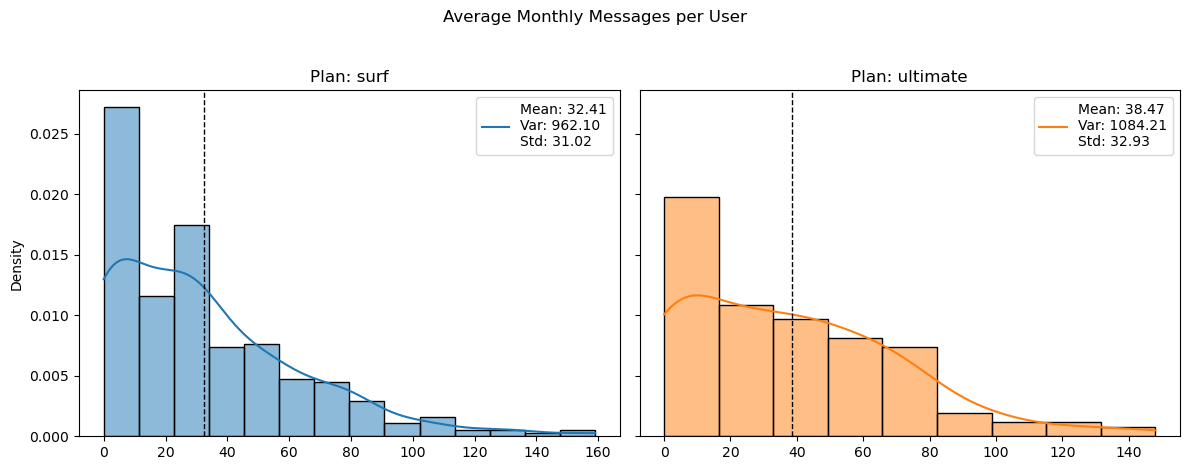

,surf,ultimate
mean,32.408931,38.471532
std,31.017777,32.927275
var,962.102515,1084.20541
mode,0,0
max,159.0,148.0
min,0.0,0.0
limit,50,1000
percent_above_limit,24.324324,0.0
percent_below_limit,75.675676,100.0
percent_above_mean,38.438438,45.859873


In [33]:
# Plot and Save for Messages
plot_hist(average_monthly_usage_per_user, 'messages', 'plan', 'Average Monthly Messages per User', save=True)
plot_hist_sbs(average_monthly_usage_per_user, 'messages', 'plan', 'Average Monthly Messages per User', save=True)
display(calculate_stats(average_monthly_usage_per_user, 'messages', 'plan'))

#### Describe the distributions:

- **Central Tendency and Shape:** The histograms for messages sent per user are significantly right-skewed for both plans, indicating that most users send only a few messages per month, with a steep drop-off as the count increases. The mean of approximately 32.41 messages for Surf and 38.47 for Ultimate again suggests similarity in usage between the plans. Notably, the statistical mode for both plans is 0, reflecting that the most common number of messages sent by users is none, pointing towards a preference for other forms of communication or inactive users.

- **Spread and Variability:** The standard deviations, close to 31 for Surf and 33 for Ultimate, are almost as large as the means themselves, indicating a wide spread of data and significant variability in the number of messages sent by users. This is further supported by the variance figures, which are also quite substantial relative to the means.

- **Outliers and Skewness:** The histograms show a long tail toward the higher message counts, suggesting the presence of a smaller number of heavy texters. The maximum values (159 for Surf and 148 for Ultimate) are several times larger than the mean, contributing to the skewness of the distribution.

- **Plan Limits:** The Surf plan includes 50 messages, while the Ultimate plan offers a generous 1000 messages. About 24% of Surf users exceed their messaging limit, which indicates that for a quarter of the Surf users, the included messages may not be sufficient. In contrast, none of the Ultimate plan users exceed their generous limit.


While the distributions for both plans show that messaging is not a heavily used service, with the most common value being 0, and that difference in average usage between plans is small, there are distinct differences in behavior between the plans when considering overages. Surf users are occasionally exceeding their limits, which is not observed in the Ultimate plan.


### MB Data

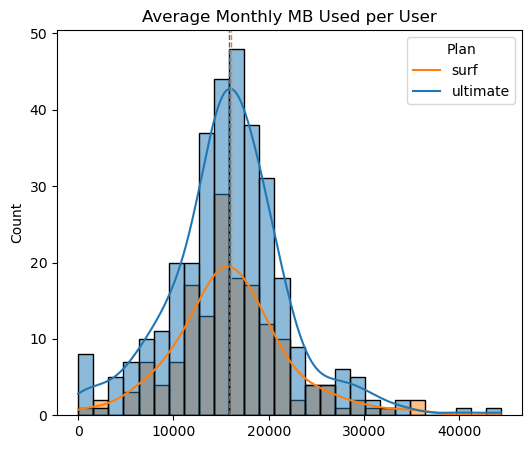

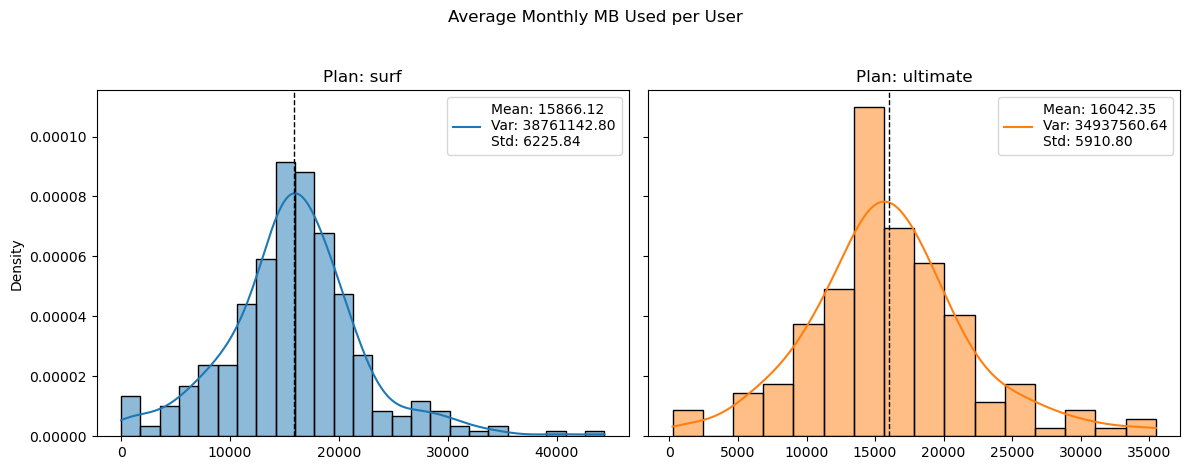

,surf,ultimate
mean,15866.11598,16042.345402
std,6225.844746,5910.800338
var,38761142.797187,34937560.639812
mode,333 modes found,157 modes found
max,44351.945,35469.031818
min,0.0,233.17
limit,15360,30720
percent_above_limit,54.354354,1.910828
percent_below_limit,45.645646,98.089172
percent_above_mean,50.750751,46.496815


In [34]:
# Plot and Save for MB Used
plot_hist(average_monthly_usage_per_user, 'mb_used', 'plan', 'Average Monthly MB Used per User', save=True)
plot_hist_sbs(average_monthly_usage_per_user, 'mb_used', 'plan', 'Average Monthly MB Used per User', save=True)
display(calculate_stats(average_monthly_usage_per_user, 'mb_used', 'plan'))

#### Describe the distributions: 

- **Central Tendency and Shape:** For MB used data, both Surf and Ultimate plans show distributions that a near a normal distribution, with a notable right skewness indicating a tail of users consuming a significantly higher amount of data. The mean data usage for Surf users is approximately 15,866 MB (15.5 GB), while for Ultimate users, it's about 16,042 MB (15.6 GB), a near negligible difference in average usage. 

- **Outliers and Skewness:** The maximum data usage for Surf and Ultimate users are 44,351.945 MB and 35,469.031818 MB, respectively, which far exceeds the average usage, contributing to the right skewness of the distribution. This skewness is indicative of a subset of users who utilize significantly more data than the average. Interestingly, the max value for the Surf plan is higher than the max value for the Ultimate plan. We can also see that more Surf plan users exceed the mean usage than Ultimate users (50% compared to 46%).

- **Variance:** Surprisingly, the Surf plan shows more variance in MB usage than the more generous Ultimate plan. The greater variance in for the Surf plan and near match for average usage suggests that Surf plan users are using internet services at least as liberally as their Ultimate plan counter parts.  

- **Plan Limits:** The Surf plan has a data limit of 15,360 MB (15 GB), and the Ultimate plan's limit is 30,720 MB (30 GB). Notably, 54.35% of Surf users exceed their data limit, suggesting that more than half of the Surf users need more data than their plan provides. Conversely, only about 1.91% of Ultimate plan users exceed their data limit, indicating that the data allowance for the Ultimate plan is generally sufficient for the vast majority of its users.

The MB used data for both plans illustrates a pattern of usage that exceeds the plan limits for a significant portion of Surf users, in contrast to the Ultimate plan, where the data limit suffices for most. The distributions' right skewness and the variability in data usage highlight the diverse needs of the customer base, with a considerable number of users consuming data well above the average. 


### Revenue Data

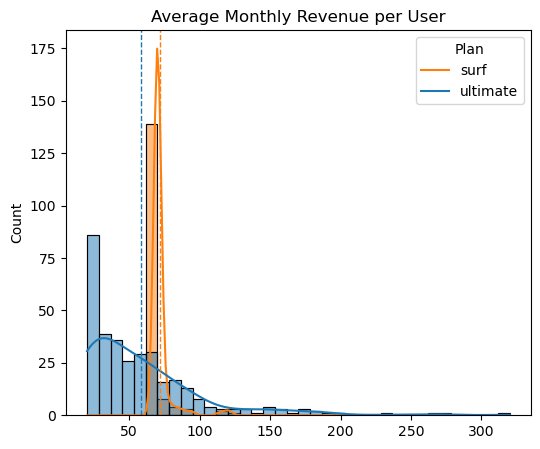

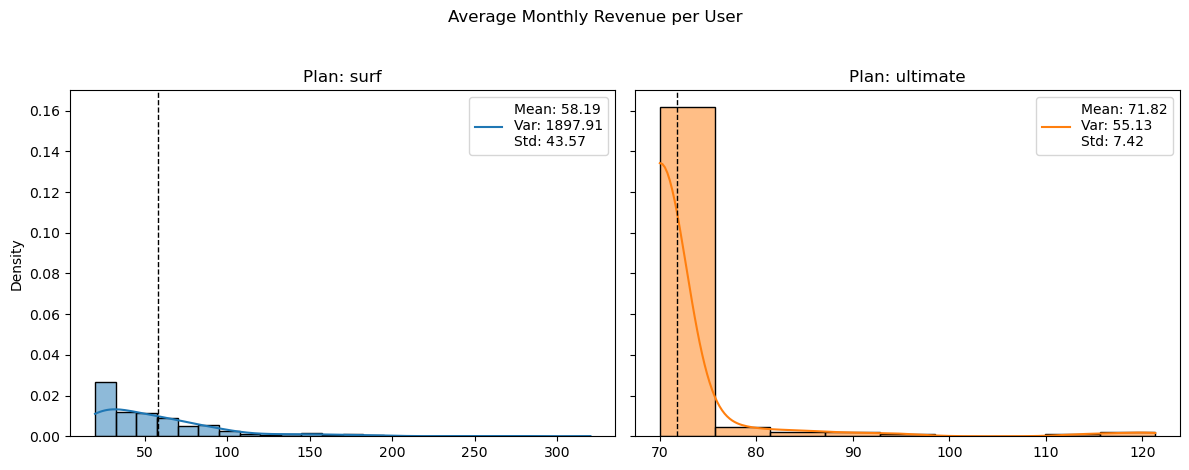

,surf,ultimate
mean,58.194344,71.823284
std,43.565028,7.424766
var,1897.911623,55.127147
mode,20,70
max,320.185,121.333333
min,20.0,70.0
limit,NaN,NaN
percent_above_limit,NaN,NaN
percent_below_limit,NaN,NaN
percent_above_mean,36.936937,9.55414


In [35]:
# Plot and Save for Revenue
plot_hist(average_monthly_usage_per_user, 'revenue', 'plan', 'Average Monthly Revenue per User', save=True)
plot_hist_sbs(average_monthly_usage_per_user, 'revenue', 'plan', 'Average Monthly Revenue per User', save=True)
display(calculate_stats(average_monthly_usage_per_user, 'revenue', 'plan'))

#### Describe the distributions: 

- **Central Tendency and Shape:** The revenue distributions for Surf and Ultimate plans are markedly distinct from each other and from the distributions of calls, minutes, messages, and MB used. The Surf plan shows a wide spread in revenue, with a mean of approximately $58.19, and exhibits significant right skewness, indicated by a mode of $20 (the monthly plan fee) and a maximum revenue of $320.185. This spread is much broader than seen in the Ultimate plan, which has a tighter distribution around the mean of $71.82, a mode at the monthly fee of $70, and a relatively low standard deviation of $7.42, suggesting most revenues are clustered closely around the plan's base cost.

- **Spread and Variability:** The standard deviation and variance for the Surf plan are considerably higher than those for the Ultimate plan, highlighting a greater variability in revenue generated from Surf users. This difference in spread reflects the contrasting billing structures of the plans: Surf users, with more variable usage and overages, contribute to a wider range of revenues, whereas Ultimate users generally stay within their generous plan limits.

- **Contextual Comparison:** When comparing these revenue distributions to the distributions of calls, minutes, messages, and MB used, it's clear that the revenue for the Surf plan is influenced by variable user behavior, including overages. In contrast, the Ultimate plan's revenue distribution is more predictable and less variable, mirroring the more consistent usage patterns observed in the other data sets.

- **Outliers and Skewness:** The Surf plan's revenue distribution, with its long tail to the right, suggests the presence of outliers - users generating significantly higher revenue through overages. This is in stark contrast to the Ultimate plan, where the distribution's tight clustering around the mean indicates fewer outliers and overages, as supported by the minimal standard deviation.

Surf's plan structure, with lower limits on usage, leads to a wide variability in revenue, reflecting a broader range of user behaviors and frequent overages. In contrast, Ultimate's higher monthly fee and generous usage limits result in a more uniform revenue pattern, with most users' charges aligning closely with the plan fee.


# Test the Hypotheses:

## Hypothesis 1:
**Null Hypothesis:** There is no difference between the average revenue for Ultimate and Surf plans.  
**Alternative Hypothesis:** The average revenue from users of Ultimate and Surf calling plans differs.

In [36]:
# Define the groups
surf_group = average_monthly_usage_per_user.query('plan == "surf"')
ultimate_group = average_monthly_usage_per_user.query('plan == "ultimate"')

In [37]:
# Define the Samples for hypothesis 1 t-test
sample1 = surf_group['revenue']
sample2 = ultimate_group['revenue']

# Test the hypothesis
alpha = 0.05  # set the alpha value to 0.05 per common practice in business

# Use ind: each sample has no relationship to the other
# equal_var=False considering the significant difference in variances
pvalue = stats.ttest_ind(sample1, sample2, equal_var=False).pvalue
if pvalue < alpha:
    print('Reject the null hypothesis.\nNull hypothesis: "There is no difference in revenue between the Surf and Ultimate plans"')
else:
    print('Cannot reject the null hypothesis.\nNull hypothesis: "There is no difference in revenue between the Surf and Ultimate plans"')

Reject the null hypothesis.
Null hypothesis: "There is no difference in revenue between the Surf and Ultimate plans"


### Conclusion:  

The T-test reinforces what we had gathered from the visual interpretation of the revenues for Surf vs. Ultimate: on average, the Ultimate plan brings in more revenue per user than the Surf plan.

## Hypothesis 2:
**Null Hypothesis:** There is no difference between the average revenue for users in the NY-NJ area vs users from all other regions.  
**Alternative Hypothesis:** The average revenue from users in NY-NJ area is different from that of the users from all other regions. 

### Additional Transform and Feature Engineer

In [38]:
# Transform the data to consider User's State

# Modify the users DataFrame to include if the user is in NY or NJ
# Add state column to the users DataFrame by taking everything after the comma in the city column
users['state'] = users['city'].str.split(',').str[1].str.strip()
# Remove "MSA" from the state column
users['state'] = users['state'].str.replace('MSA', '').str.strip()
# Create new column "in_NY-NJ" to indicate if the user is in NY or NJ. Boolean type
users['in_NY-NJ'] = users['state'].str.contains('NY|NJ')
users.info()
print()
print(users['in_NY-NJ'].value_counts())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   user_id     500 non-null    object        
 1   first_name  500 non-null    object        
 2   last_name   500 non-null    object        
 3   age         500 non-null    int64         
 4   city        500 non-null    object        
 5   reg_date    500 non-null    datetime64[ns]
 6   plan        500 non-null    object        
 7   churn_date  34 non-null     datetime64[ns]
 8   state       500 non-null    object        
 9   in_NY-NJ    500 non-null    bool          
dtypes: bool(1), datetime64[ns](2), int64(1), object(6)
memory usage: 35.8+ KB

in_NY-NJ
False    397
True     103
Name: count, dtype: int64


In [39]:
# Merge the average_monthly_usage_per_user DataFrame with the users DataFrame on user_id to include if the user is in NY or NJ
average_monthly_usage_per_user = average_monthly_usage_per_user.merge(
    users[['user_id', 'in_NY-NJ']], on='user_id', how='left')
average_monthly_usage_per_user.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 490 entries, 0 to 489
Data columns (total 9 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   plan      490 non-null    object 
 1   user_id   490 non-null    object 
 2   month     490 non-null    float64
 3   calls     490 non-null    float64
 4   minutes   490 non-null    float64
 5   messages  490 non-null    float64
 6   mb_used   490 non-null    float64
 7   revenue   490 non-null    float64
 8   in_NY-NJ  490 non-null    bool   
dtypes: bool(1), float64(6), object(2)
memory usage: 31.2+ KB


### Plotting NY-NJ VS All other states:

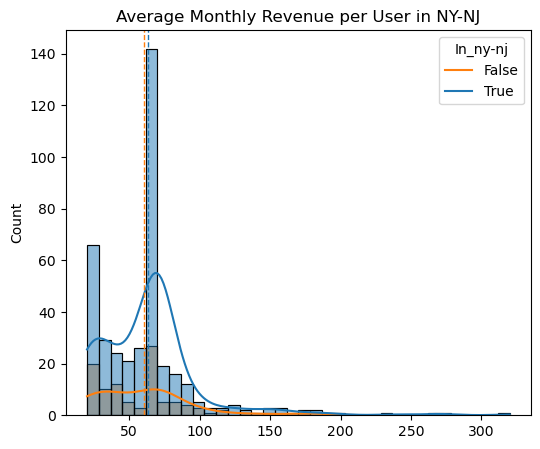

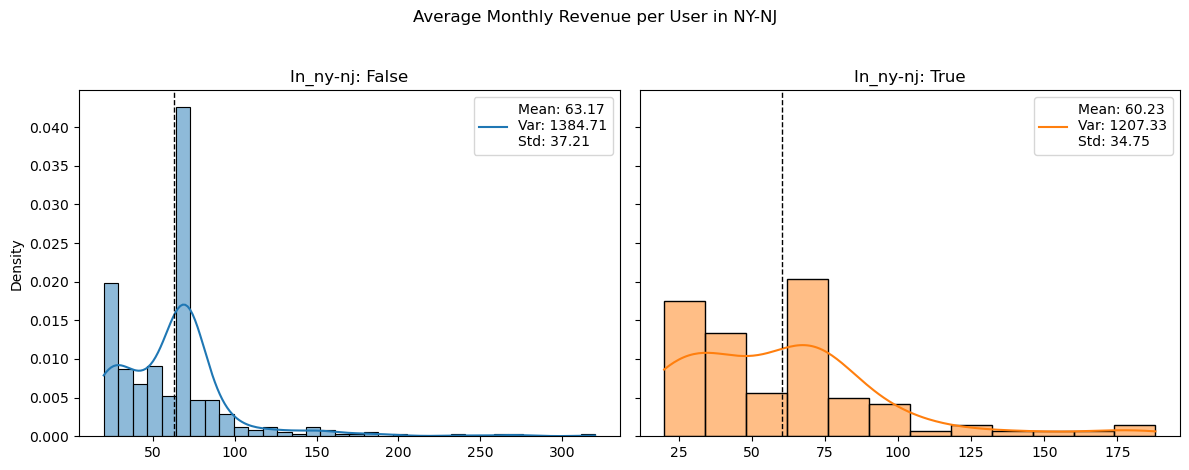

,False,True
mean,63.174252,60.229042
std,37.21175,34.746609
var,1384.714303,1207.326866
mode,70,70
max,320.185,188.0
min,20.0,20.0
limit,NaN,NaN
percent_above_limit,NaN,NaN
percent_below_limit,NaN,NaN
percent_above_mean,56.958763,50.980392


In [40]:
# Plot and Save for for in_NY-NJ
plot_hist(average_monthly_usage_per_user, 'revenue', 'in_NY-NJ', 'Average Monthly Revenue per User in NY-NJ', save=True)
plot_hist_sbs(average_monthly_usage_per_user, 'revenue', 'in_NY-NJ', 'Average Monthly Revenue per User in NY-NJ', save=True)
display(calculate_stats(average_monthly_usage_per_user, 'revenue', 'in_NY-NJ'))

### Testing

In [41]:
# Define the groups for testing
ny_nj_group = average_monthly_usage_per_user.query('`in_NY-NJ` == True')
other_group = average_monthly_usage_per_user.query('`in_NY-NJ` == False')

# Define the Samples for hypothesis 2 t-test
sample1 = ny_nj_group['revenue']
sample2 = other_group['revenue']

# Test the hypothesis
# Use ind: each sample has no relationship to the other
# Use .levene to check for equal variance
if stats.levene(sample1, sample2).pvalue < .05:  # Separate alpha for levene test
    var_option = False
else:
    var_option = True
print(f'EQUAL_VAR IS SET TO {var_option}\n')

# Test the hypothesis with varying alpha values
alpha_values = [0.01, 0.05, 0.10, 0.15, 0.20]

for alpha in alpha_values:
    pvalue = stats.ttest_ind(sample1, sample2, equal_var=var_option).pvalue
    if pvalue < alpha:
        print(
            f'Reject the null hypothesis at alpha = {alpha}.\nNull hypothesis: "There is no difference in revenue between users in NY-NJ and other states"')
    else:
        print(
            f'Cannot reject the null hypothesis at alpha = {alpha}.\nNull hypothesis: "There is no difference in revenue between users in NY-NJ and other states"')
    print()

EQUAL_VAR IS SET TO True

Cannot reject the null hypothesis at alpha = 0.01.
Null hypothesis: "There is no difference in revenue between users in NY-NJ and other states"

Cannot reject the null hypothesis at alpha = 0.05.
Null hypothesis: "There is no difference in revenue between users in NY-NJ and other states"

Cannot reject the null hypothesis at alpha = 0.1.
Null hypothesis: "There is no difference in revenue between users in NY-NJ and other states"

Cannot reject the null hypothesis at alpha = 0.15.
Null hypothesis: "There is no difference in revenue between users in NY-NJ and other states"

Cannot reject the null hypothesis at alpha = 0.2.
Null hypothesis: "There is no difference in revenue between users in NY-NJ and other states"



### Conclusion:  
We can reject the (alternative) hypothesis that there is a significant difference in average monthly revenue between NY-NJ users and users from all other states with a high level of confidence considering the results with an Alpha value of up to .2 

# Overall Conclusion:  

The average usage distribution for minutes and data both approximate a normal distribution (with a slight right skew). Usage between Surf users and Ultimate users is about the same for both metrics as well. For both metrics, a significant portion of Surf users exceed their plan limits (33% for minutes and 54% for data) while very few Ultimate users exceed their limits (0% for minutes and less than 2% for data).  

Much like distributions for minutes and data, messages shows similar usage between plans with the Ultimate users averaging only 4 more messages a month than Surf users. Again, we also see a significant portion of Surf users exceeding their messaging limit (24%) while 0% of Ultimate users exceed their limit.  

However, messages and revenue show significantly right skewed distributions where the bulk of usage / revenue is at the low end with a decreasing number of users at the high end. Unlike the plots for minutes and data, these shapes cannot be described as near normal.  

Revenue is the only metric where there is a significant difference between the two plans. The Surf plan shows greater variability with a variance of 1899, while the Ultimate plan has a variance of only 55. The mean values for the two plans differ by about $14 dollars with the Ultimate plan generating more revenue on average. This was tested by the null hypothesis: "There is no difference in revenue between the Surf and Ultimate plans". This null hypothesis was rejected with the standard alpha value of .05 and the more stringent .02 value, insuring we can be confident in our analysis. 

The null hypothesis "There is no difference in revenue between users in NY-NJ and other states" was also tested with a range of alpha values from .01 to .2. in each case, it was concluded that the null hypothesis could not be rejected. Which is to say, there does not look to be a significant difference in revenue generated from user within the NY-NJ area vs the rest of the US. 